**COVID-19 INFECCION EN ECUADOR. MODELOS PROBABILISTICOS**

Implementacion de un modelo probabilistico de infección por el virus Covid-19

Se realiza un análisis probabilistico simple del crecimiento de la infección en Python y el modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de probabilidad.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(url)
df = df.loc[:,['date','total_cases','location']]
df=df.loc[df['location'] == 'Ecuador']
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-22", FMT)).days)
##Eliminamos las filas en las que los casos tenian un total de cero, dejando unicamente donde empezaron los contagios
df= df[df['total_cases'] != 0]
df

,date,total_cases,location
3437,39,1,Ecuador
3438,40,6,Ecuador
3439,41,7,Ecuador
3440,43,10,Ecuador
3441,44,13,Ecuador
3442,47,14,Ecuador
3443,48,15,Ecuador
3444,49,17,Ecuador
3445,52,23,Ecuador
3446,53,28,Ecuador


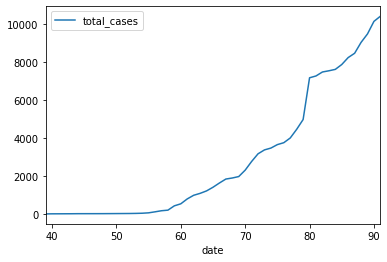

In [2]:
df.plot(x ='date', y='total_cases')

**1. COMPARAR EL MODELO DE PREDICCION MATEMATICO VS PROBABILIDAD.**

**MODELO PROBABILISTICO**

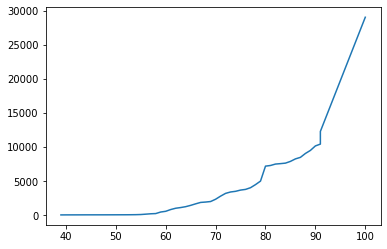

In [11]:
filtro = df.iloc [:, 1] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
y = list(df.iloc [:, 1]) # Total casos
x = list(df.iloc [:, 0]) # Dias
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x,y)
plt.show()

**MODELO POLINOMIAL**

58


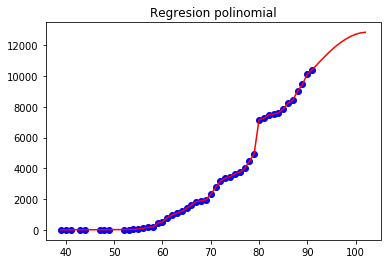

In [4]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
x1 = list(df.iloc [:, 0])
y1 = list(df.iloc [:, 1])
X = df.iloc[:, 0:1].values 
lin = LinearRegression() 
lin.fit(X, y1) 
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X) 
poly.fit(X_poly, y1) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y1) 
plt.scatter(X, y1, color = 'blue') 

X1 = np.array(range(93,103))
for i in X1:
    x1.append(i)
pre = lin2.predict(poly.fit_transform(X1.reshape(-1, 1)))
for i in pre:
    y1.append(i)
    
print(len(x1))
plt.plot(x1, y1, color = 'r') 
plt.title('Regresion polinomial') 
plt.show() 

**2.SIR MODELO DE PROBABILIDAD**

In [12]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(url)
df = df.loc[:,['date','total_cases','location']]
df=df.loc[df['location'] == 'Ecuador']
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-22", FMT)).days)
##Eliminamos las filas en las que los casos tenian un total de cero, dejando unicamente donde empezaron los contagios
df= df[df['total_cases'] != 0]
filtro = df.iloc [:, 1] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
y = list(df.iloc [:, 1]) # Total casos
x = list(df.iloc [:, 0]) # Dias
for i in range(x[-1], x[-1]+10):
    x.append(i)
    y.append(int(y[-1] + mediana))

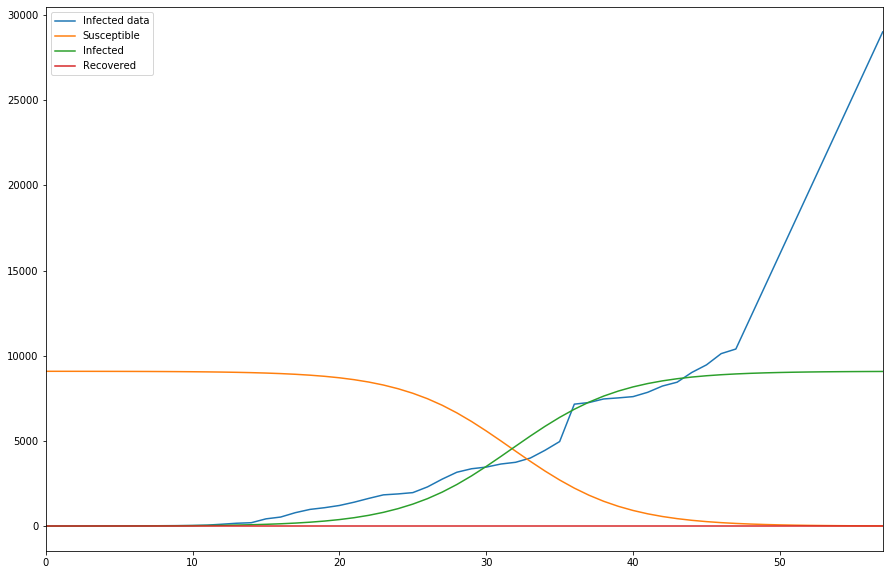

In [13]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, s0, i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
i0=2
r0=10
s0=9090
x=np.array(range(0,58))
data= y
optimal = minimize(loss, [0.001, 0.001], args=(data,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00000001,0.4), (0.00000001, 0.4)])   
beta, gamma = optimal.x
def predict(beta, gamma, data, s0, i0, r0):
    new_index = np.array(range(0,58))
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data, [None] * (size - len(data))))
    return new_index, extended_actual, solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1))

new_index, extended_actual,prediction = predict(beta, gamma, data,s0,i0,r0)
df = pd.DataFrame({'Infected data': y,'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
fig, ax = plt.subplots(figsize=(15, 10))
df.plot(ax=ax)

**2. SIR MODELO DE REGRESION POLINOMIAL**

In [7]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
x1 = list(df.iloc [:, 0])
y1 = list(df.iloc [:, 1])
X = df.iloc[:, 0:1].values 
lin = LinearRegression() 
lin.fit(X, y1) 
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X) 
poly.fit(X_poly, y1) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y1) 
X1 = np.array(range(93,103))
for i in X1:
    x1.append(i)
pre = lin2.predict(poly.fit_transform(X1.reshape(-1, 1)))
for i in pre:
    y1.append(i)
    
print(len(x1))


58


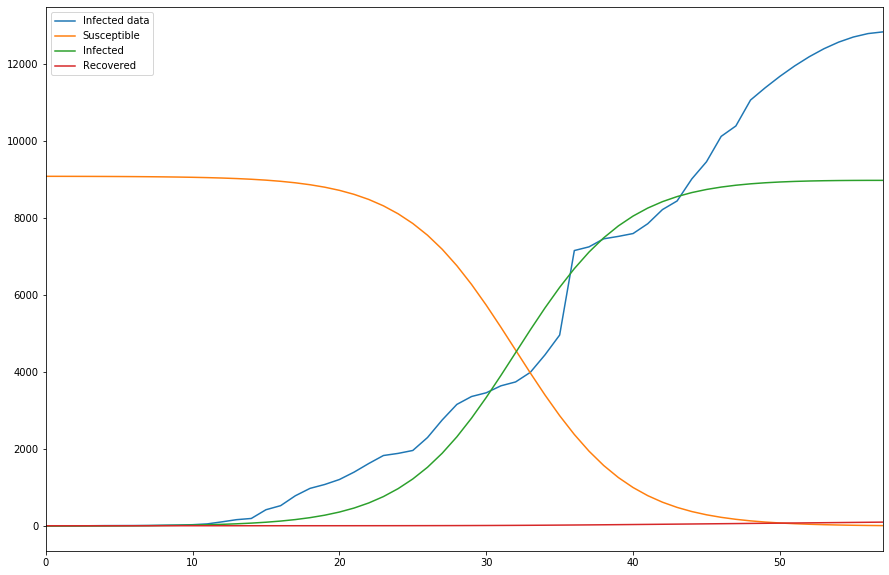

In [8]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint

def loss(point, data, s0, i0, r0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))
i0=2
r0=10
s0=9090
x=np.array(range(0,58))
data= y1
optimal = minimize(loss, [0.001, 0.001], args=(data,s0,i0, r0), method='L-BFGS-B', bounds=[(0.00000001,0.4), (0.00000001, 0.4)])   
beta, gamma = optimal.x
def predict(beta, gamma, data, s0, i0, r0):
    new_index = np.array(range(0,58))
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data, [None] * (size - len(data))))
    return new_index, extended_actual, solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1))

new_index, extended_actual,prediction = predict(beta, gamma, data,s0,i0,r0)
df = pd.DataFrame({'Infected data': y1,'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
fig, ax = plt.subplots(figsize=(15, 10))
df.plot(ax=ax)

**3.- Retroceder un semana y comparar el modelo matematico vs probabilidad vs reales. Solo cargan los datos para generar los modelos menos 7 dias.**

**Modelo de probabilidad**

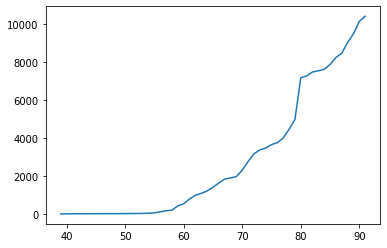

In [22]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(url)
df = df.loc[:,['date','total_cases','location']]
df=df.loc[df['location'] == 'Ecuador']
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-22", FMT)).days)
##Eliminamos las filas en las que los casos tenian un total de cero, dejando unicamente donde empezaron los contagios
df= df[df['total_cases'] != 0]
filtro = df.iloc [:, 1] # Filtro los datos que se empezo a tener casos
#Obtenemos la mediana
media = filtro.mean()
mediana = filtro.median()
y = list(df.iloc [:, 1]) # Total casos
x = list(df.iloc [:, 0]) # Dias
for i in range(x[-1], x[-1]):
    x.append(i)
    y.append(int(y[-1] + mediana))
plt.plot(x,y)
plt.show()

**Modelo de regresión polinomial**

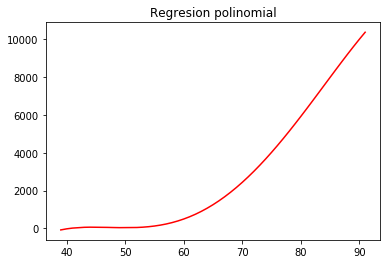

In [21]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(url)
df = df.loc[:,['date','total_cases','location']]
df=df.loc[df['location'] == 'Ecuador']
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-22", FMT)).days)
##Eliminamos las filas en las que los casos tenian un total de cero, dejando unicamente donde empezaron los contagios
df= df[df['total_cases'] != 0]
x1 = list(df.iloc [:, 0])
y1 = list(df.iloc [:, 1])
X = df.iloc[:, 0:1].values 
lin = LinearRegression() 
lin.fit(X, y1) 
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X) 
poly.fit(X_poly, y1) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y1) 
plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red') 
plt.title('Regresion polinomial')                   
plt.show()

**ANALISIS**

- En el caso de modelos probabilísticos, debido a la naturaleza misma del modelo, las observaciones son sólo una muestra de la realidad, y en consecuencia una repetición del ensayo puede dar un resultado diferente. Resulta, pues, poco probable encontrar una correspondencia exacta entre modelo y realidad, aún cuando las hipótesis sean válidas. Por ello, es necesario definir la magnitud de la discrepancia que puede obtenerse sin que sea necesario desechar la hipótesis estudiada. Al ser la variable observada una variable aleatoria, pueden producirse grandes diferencias, aun cuando ello sea poco probable. Por otro lado, una correspondencia entre la predicción y la observación tampoco es suficiente para garantizar que la hipótesis sea cierta.

- los resultados obtenidos con los datos de regresión polinomial de ordenación cuatro, son los que presentan menor desviación estándar, simplifican el tratamiento de datos, permitiendo un análisis más riguroso de los resultados.

**CONCLUSIONES**

Mediante la regresión polinómica se reduce considerablemente los errores en el ajuste de la función que describe el comportamiento de la variable dependiente y así ajustar los valores a una función que los represente de manera correcta.

**CRITERIO PERSONAL**

Al realizar la práctica podemos deducir que el uso de regresión polinomial para el ajuste de datos y estimacino de predicciones es más considerable que la probabilistica. Aunque de cierto modo no se apega a la realidad actual, debido a que no se consta con datos precisos.